#### Data 612 - Project 2 : Content-Based and Collaborative Filtering<br>Date: June 18, 2019<br>Team Info: 
+ Christina Valore
+ Juliann McEachern 
+ Rajwant Mishra

<h1 align="center">Goodreads Books Recommender Systems</h1>

## Overview

Our recommender systems were built from the following datasets, obtained from [goodbooks2017](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/):
+  `books`
+  `book_tags`
+  `tags`
+  `ratings`

#### Dependencies

The following python dependecies are required for replication of our work:

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, sys, os, ipywidgets as widgets, sklearn.metrics, surprise
from collections import defaultdict
from contextlib import contextmanager
from fuzzywuzzy import fuzz, process
from IPython.display import display, clear_output
from math import sqrt
from scipy.spatial.distance import correlation, cosine
from sklearn.metrics import pairwise_distances, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy
global k,metric

#### Data load

After loading the necessary packages, we imported the goodbooks datasets from our GitHub repository. We did an initial clean on the data and then conducted additional transformations that corresponded with our different recommender systems. 

In [6]:
# Load data from local csv  into pandas dataframe
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv')
book_tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip')

# Clean ratings data
ratings = ratings.drop('ratings.csv', axis=1)
ratings = ratings[:-1].astype(int)

# Clean books data
## select only books writen in english 
filter_list = ['eng', 'en-US', 'en-GB', 'en-CA', 'en']
books_df = books[books.language_code.isin(filter_list)]

## subset columns
books_df = books_df[['book_id', 'goodreads_book_id', 'isbn', 'authors', 'title', 'original_publication_year', 'average_rating']]

## drop 15 occurances of no publication year
books_df = books_df.dropna(axis=0, subset=['original_publication_year'])

## change publication year data type to int
books_df['original_publication_year'] = books_df['original_publication_year'].astype(int)

# preview books dataframe:
books_df.head()

,book_id,goodreads_book_id,isbn,authors,title,original_publication_year,average_rating
0,1,2767052,439023483,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",2008,4.34
1,2,3,439554934,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,4.44
2,3,41865,316015849,Stephenie Meyer,"Twilight (Twilight, #1)",2005,3.57
3,4,2657,61120081,Harper Lee,To Kill a Mockingbird,1960,4.25
4,5,4671,743273567,F. Scott Fitzgerald,The Great Gatsby,1925,3.89


#### Visualization

We wanted to see the range of book ratings from the `ratings` dataset compared to our average ratings from the `book` dataset. Using a bar graph, we found that most users rated books 3 or greater, while 1 and 2 ratings were sparse. And, the histogram of average ratings presented with similiar findings, which showed the data to have a normal distribution, centered around 4, with a left skew.

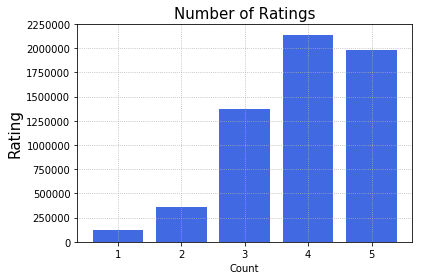

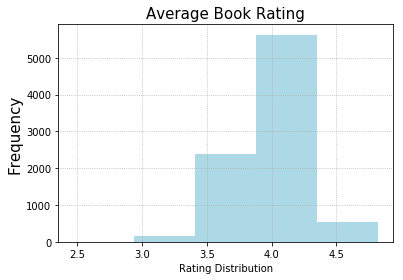

In [3]:
# graph to see the rating scale goes from 1-5, with very few 1 and 2 rating
rts_gp = ratings.groupby(by=['rating']).agg({'user_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

plt.bar(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Number of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

# average rating histogram
plt.hist(books_df.average_rating, color='lightblue', bins = 5)
plt.title('Average Book Rating', fontsize=15)
plt.xlabel('Rating Distribution', fontsize=10)
plt.ylabel('Frequency', fontsize=15)
plt.grid(ls='dotted')
plt.show()

## Content-Based Filtering 

We first created a content-based recommender system, through which we individually filtered user recommendations based on unique, item profiles using our `book`, `book_tag`, and `tags` datasets.

#### Item Profile 

Using a few data transformations, we create individual item profiles, which features include concatenated tags describing each book. 

In [4]:
# CBF Data Cleaning
## subset necessary columns
subset_books = books_df[['goodreads_book_id', 'title', 'authors']]

# join tags and books with tags
join_tags = book_tags.set_index('tag_id').join(tags.set_index('tag_id')).drop('count', axis=1)
join_book = pd.merge(subset_books, join_tags, on='goodreads_book_id')
CBF_tags = join_book.groupby(['goodreads_book_id','title','authors'],
                             as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1)


We passed the tags column (or profile) as a vector through a term frequency times inverse document frequency (TF-IDF) matrix. This process mines and scores important words from the profile. 

We then created the cosine similiarity matrices for book tags to make our recomendation predictions. Finally, we build a `CBF_recommend function`, which uses the cosine similarities  to identify the top *n* matches for a particular book based solely on it's profile.  

In [5]:
# Generate TF-IDF matrix for tags
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

# Generate cosine similarity matrix for tags 
tf_idf_matrix = vectorizer.fit_transform(CBF_tags['tags'])
co_sim = linear_kernel(tf_idf_matrix, tf_idf_matrix)

# Create list to match title indices in function
indices = pd.Series(data=CBF_tags.index, index=CBF_tags['title']) 

# Book recommendation function 
def CBF_recommend(title, n):
    if n > 0: # logical statement to ensure valid input for n
        recommendations = CBF_tags[['title', 'authors']] # set recommendation output: title, author
        idx = indices[title] # set index to title
        
        # list and sort similarity scores 
        score = pd.DataFrame(enumerate(co_sim[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
  
        # recommend top n books 
        top_n = score[1:n+1]
        test = recommendations.iloc[top_n.index].join(top_n)
        test.index = np.arange(1, len(test) + 1)
        return test
    else: 
        print("Select a value greater than 0 and try again.")

#### Content-Based Filtering Examples

The following examples are used to test our `CBF_recommend function` and view correlation score of recommended books. 

In [6]:
CBF_recommend('To Kill a Mockingbird', 3)

,title,authors,score
1,Of Mice and Men,John Steinbeck,0.520756
2,The Great Gatsby,F. Scott Fitzgerald,0.512937
3,Lord of the Flies,William Golding,0.495611


In [7]:
CBF_recommend('Nineteen Minutes', 3)

,title,authors,score
1,The Tenth Circle,Jodi Picoult,0.352290
2,Salem Falls,Jodi Picoult,0.344947
3,Handle with Care,Jodi Picoult,0.323359


In [8]:
CBF_recommend('A Game of Thrones (A Song of Ice and Fire, #1)', 3)

,title,authors,score
1,"A Feast for Crows (A Song of Ice and Fire, #4)",George R.R. Martin,0.685404
2,"A Dance with Dragons (A Song of Ice and Fire, #5)",George R.R. Martin,0.676312
3,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,0.661021


#### Content-Based Recommendations from User Input 

The `booksearch function` below allows users to search for book titles within our goodbooks compilation. Users can take the output to guide their search for specific item recommendations. 

In [9]:
choices = CBF_tags['title']
search_value = input("Search book titles: ")

def booksearch(title):
    fuzzy = process.extract(search_value, choices)
    results = [x[0] for x in fuzzy]
    print("\n".join(str(x) for x in results))

booksearch(search_value)

Search book titles: giving
The Giving Tree
We the Living
How to Stop Worrying and Start Living
Death: The High Cost of Living Collected
Living History


We also created a `title_recommendations function`, which uses the `fuzzy` package to find the best title matches from the user's input and runs the selection through our content-based recommender. We found this best as many of the titles from the goodreads collection had specific title formatting the average user may not be aware of. This function also allows users to select the number of recommendations they wish to receive. 

In [10]:
title_input = input("Input book title to view recommendations: ")
    
def title_recommendations(title): 
    recommend_n = input("Input number of recommendations you would like to receive: ")
    user_selection = process.extractOne(title_input, choices)[0]
    print("\n Recommending titles based on the book: ",user_selection)
    return CBF_recommend(user_selection, int(recommend_n))

title_recommendations(title_input)

Input book title to view recommendations: giving
Input number of recommendations you would like to receive: 10

 Recommending titles based on the book:  The Giving Tree


,title,authors,score
1,"Oh, The Places You'll Go!",Dr. Seuss,0.706781
2,A Light in the Attic,Shel Silverstein,0.696062
3,The Velveteen Rabbit,"Margery Williams Bianco, William Nicholson",0.680955
4,The Poky Little Puppy (A Little Golden Book),"Janette Sebring Lowrey, Gustaf Tenggren",0.634173
5,Where the Wild Things Are,Maurice Sendak,0.631628
6,Green Eggs and Ham,"Dr. Seuss, לאה נאור",0.630845
7,Curious George,H.A. Rey,0.611664
8,The Lorax,Dr. Seuss,0.606271
9,"Alexander and the Terrible, Horrible, No Good,...","Judith Viorst, Ray Cruz",0.606162
10,Goodnight Moon,"Margaret Wise Brown, Clement Hurd",0.606032


#### Content-Based Analysis

Upon initial review, the `CBF_recommend` function appears to match book recommendations very effectively based the created item profiles. This method works nicely because it does not require data on other users and does not rate our items based on popularity. 

However, we found this method suffered from a common drawback of the content-based approach, over-specification. Unlike the "To Kill a Mockingbird" recommendations, we see that the top recommender results for "Nineteen Minutes" and "A Game of Thrones" are for other novels written by the same authors as the book we searched for.  

## User-User Collaborative Filtering 

Our next system was created using user-user collaborative filtering methods. According to [Towards Data Science](https://towardsdatascience.com/), user-user collaborative filtering is defined as: "products [that] are recommended to a user based on the fact that the products have been liked by users similar to the user. For example if Derrick and Dennis like the same movies and a new movie comes out that Derick likes,then we can recommend that movie to Dennis because Derrick and Dennis seem to like the same movies."

For this section, we focused on using the `suprise` package, which is a library specifically for building and testing recommender systems. The two methods we tested out are neighborhood methods and matrix factorization. 

#### Data Preparation

We intially tried to run the entire set, however the kernel would stop - too much data! So, we subsetted the data by taking a random sample of 10,000 ratings and matched it against the books data.

In [11]:
# took a smaller subset of the ratings and 
# combined the books and ratings data frames on book_id 
sub_ratings=ratings.sample(n=10000)
combined = pd.merge(books, sub_ratings, on = 'book_id')

# subsetting the movie-ratings data to only include columns needed for this analysis
subset_ratings_movies = combined[['book_id', 'user_id','rating', 'title']]

subset_ratings_movies.head()

,book_id,user_id,rating,title
0,1,15124,5,"The Hunger Games (The Hunger Games, #1)"
1,1,49970,5,"The Hunger Games (The Hunger Games, #1)"
2,1,20546,5,"The Hunger Games (The Hunger Games, #1)"
3,1,15073,4,"The Hunger Games (The Hunger Games, #1)"
4,1,49879,5,"The Hunger Games (The Hunger Games, #1)"


#### KNN 

We first attempted to use the KNN algorithm, or k-Nearest Neighbor for our recommender system. This algorithm assumes that things in close proximity are similar. It has been described as the idea of 'Birds of a feather flock together". The algorithm takes into account similarity by calculating the distance in between. 

The suprise package has a built in kNN function which we utilized to to train our model. We also made use of a piece of code created by suprise that prints out the top n recommended books. 

In [12]:
# The suprise package does not have native functionality to print out top recommendations, so we used the code from the FAQ section here
# https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [13]:
# Set the rating scale from 1 to 5
reader = Reader(rating_scale=(1, 5))
#load the subsetted data from above
data = Dataset.load_from_df(subset_ratings_movies[['user_id', 'book_id', 'rating']], reader)

In [14]:
# create train and test datasets, with the test size at 25% of the original
trainset, testset = train_test_split(data, test_size=0.25)

In [15]:
# use the KNN with means method to train the model
algo = KNNWithMeans(k=101, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)
# generate predictions on the test set
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [16]:
# place predictions into top function to see top predictions per user
top_n = get_top_n(predictions)

#print recommended top books for each user, commented this out as the print out was too long
#for uid, user_ratings in top_n.items():
    #print(uid, [iid for (iid, _) in user_ratings])
    
    #output example:
    #47181 [794, 123]
    #25346 [3345]
    #36659 [31]
    #51983 [548, 5417, 163]
    
#Looking at the last user_id=51983, let us see the recommended books:
books.loc[books['book_id'] == 548] #Pretty Little Liars

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
547,548,162085,162085,2191061,75,60887303,9.780061e+12,Sara Shepard,2006.0,Pretty Little Liars,...,156328,165836,8160,5743,12397,37519,47724,62453,https://images.gr-assets.com/books/1377830522m...,https://images.gr-assets.com/books/1377830522s...


In [17]:
books.loc[books['book_id'] == 5417] # E is for Evidence

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
5416,5417,64860,64860,62952,57,312939035,9.780313e+12,Sue Grafton,1988.0,E Is for Evidence,...,24206,26160,634,72,659,8053,11032,6344,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [18]:
books.loc[books['book_id'] == 163] # The Lost Hero

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
162,163,7736182,7736182,10107891,72,142311339X,9.781423e+12,Rick Riordan,2010.0,The Lost Hero,...,271576,489495,17107,5020,11267,58590,148498,266120,https://images.gr-assets.com/books/1464201003m...,https://images.gr-assets.com/books/1464201003s...


In [19]:
# check the RMSE for the test set using KNN with means method
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 1.0133


1.0132826430514505

#### SVD

We wanted to see if SVD or the singular value decomposition algorithm would help improve upon our RMSE value.

SVD works via matrix factorization by reducing the number of features of the dataset by reducing space dimensions from N to K where K < N. This SVD model is built into the suprise package.

In [20]:
# refit the model using the SVD method
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
algo.fit(trainset)

In [21]:
predictions = algo.test(testset)

# check the RMSE for the test set using the SVD model
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.9842


0.9841925758856128

#### User-User Analysis

Our results using the kNN algorithm had a very high RMSE which says our data was fitted well for the train but poorly for our test data. The hardest part was choosing a proper k value to capture enough data for a smart prediction while ignoring the noise. 

The SVD algorithm faired only slightly better in terms of RMSE, again our model does well with the trained data but not the test data. 

We would need to rework these models in order to receive any value from the predictions. 

## Item-Item Collaborative Filtering 

1. Data Sparsity: In case of large number of items, number of items a user has rated reduces to a tiny percentage making the correlation coefficient less reliable
2. User profiles change quickly and the entire system model had to be recomputed which is both time and computationally expensive
To cater to these issues, we will use ITEM-ITEM collaborative filtering.

<b>ITEM-ITEM collaborative filtering</b>
ITEM-ITEM collaborative filtering look for items that are similar to the articles that user has already rated and recommend most similar articles. But what does that mean when we say item-item similarity? In this case we don’t mean whether two items are the same by attribute like Fountain pen and pilot pen are similar because both are pen. Instead, what similarity means is how people treat two items the same in terms of like and dislike.
This method is quite stable in itself as compared to User based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

To calculate similarity between two items, we looks into the set of items the target user has rated and computes how similar they are to the target item i and then selects k most similar items. Similarity between two items is calculated by taking the ratings of the users who have rated both the items and thereafter using the cosine similarity function mentioned below.<br>
Once we have the similarity between the items, the prediction is then computed by taking a weighted average of the target user’s ratings on these similar items. The formula to calculate rating is very similar to the user based collaborative filtering except the weights are between items instead of between users. And we use the current users rating for the item or for other items, instead of other users rating for the current items.

In [22]:
k=4
metric='cosine'

# Method to show N item from Dict
def show_dict_item(n, dict_obj):
    return {k: dict_obj[k] for k in list(dict_obj)[:n]}

## starting new Test with 10K data
test_rating = ratings[1:10000]

# combined subsetted dataset 
test_rating_item = pd.merge(test_rating,books_df)
test_rating_item = test_rating_item[['book_id','title','user_id','rating']]
test_rating_item.head()

,book_id,title,user_id,rating
0,4081,I am Charlotte Simmons,2,4
1,4081,I am Charlotte Simmons,258,5
2,4081,I am Charlotte Simmons,364,4
3,4081,I am Charlotte Simmons,316,2
4,260,How to Win Friends and Influence People,2,5


In [23]:
test_M1 =pd.pivot_table(test_rating_item,index='user_id',columns='title',values='rating',fill_value=0)

test_M1.T.head()

user_id,1,2,4,6,8,9,10,11,15,18,...,429,439,440,444,446,447,449,452,453,454
title,,,,,,,,,,,,,,,,,,,,,
"Angels (Walsh Family, #3)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Salem's Lot,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"'Tis (Frank McCourt, #2)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100 Selected Poems,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Get 5 similar items from the nearest neighbour 
n = 5 
cosine_nn = NearestNeighbors(n_neighbors=n, algorithm='brute',metric='cosine')
item_cosine_nn_fit = cosine_nn.fit(test_M1.T.values)
item_distance, item_indices = item_cosine_nn_fit.kneighbors(test_M1.T.values )

In [25]:
# Cosine distance and Item 
# note this is not cosine similarlity , which can be obtained
# by doing 1 - cosine distance 
item_distance,item_indices
type(item_distance)
item_distance[1:3],item_indices[1:3]

(array([[0.        , 0.17798027, 0.22217421, 0.2602069 , 0.28073273],
        [0.        , 0.40911613, 0.41654003, 0.41654003, 0.41654003]]),
 array([[   1,  986, 1081, 1496, 1233],
        [   2,  143,  191, 1606, 2002]], dtype=int64))

In [26]:
# Here we are listing all the book and corresponding 5 recommendation 
items_dic = {}

for i in range (len(test_M1.T.index)):
    item_idx = item_indices[i]
    col_names = test_M1.T.index[item_idx].tolist()
    items_dic[test_M1.T.index[i]] = col_names

In [27]:
# List of the Book recommended by item title 
show_dict_item(2,items_dic)

{' Angels (Walsh Family, #3)': ['The Druid of Shannara (Heritage of Shannara, #2)',
  'The Elfstones of Shannara  (The Original Shannara Trilogy, #2)',
  'Intensity',
  'Rose Madder',
  'The Black Unicorn (Magic Kingdom of Landover, #2)'],
 "'Salem's Lot": ["'Salem's Lot",
  'Night Shift',
  'Pet Sematary',
  'The Dead Zone',
  'Skeleton Crew']}

In [28]:
# Lets find list of Book read by user

has_read= {}
row_indexes = {}
for i,row in test_M1.iterrows():
    rows = [x for x in range(0,len(test_M1.columns))]
    combine = list(zip(row.index,row.values,rows))
    read = [(x,z) for x,y,z in combine if y!=0]
    index = [i[1] for i in read]
    row_names = [i[0] for i in read]
    row_indexes[i] = index
    has_read[i] = row_names

In [29]:
# has_read.items()
type(has_read),show_dict_item(2,has_read)

(dict,
 {1: ['Balzac and the Little Chinese Seamstress',
   'Gilead (Gilead, #1)',
   'Housekeeping',
   'Never Let Me Go',
   'The Book Thief',
   'The History of Love',
   'The Sea'],
  2: ['Harry Potter Collection (Harry Potter, #1-6)',
   'Heart of Darkness',
   'How to Win Friends and Influence People',
   'I am Charlotte Simmons',
   'Memoirs of a Geisha',
   'The Da Vinci Code (Robert Langdon, #2)',
   'The Drama of the Gifted Child: The Search for the True Self',
   'The House of God',
   'The Millionaire Next Door: The Surprising Secrets of Americas Wealthy',
   'Who Moved My Cheese?']})

In [30]:
#row_indexes.items(),
type(row_indexes),show_dict_item(2,row_indexes)

(dict,
 {1: [197, 581, 688, 977, 1405, 1616, 1875],
  2: [633, 647, 692, 705, 899, 1486, 1518, 1629, 1737, 2162]})

In [31]:
item_indices[1:5]

array([[   1,  986, 1081, 1496, 1233],
       [   2,  143,  191, 1606, 2002],
       [  11,    3,  256,   69, 1764],
       [   4, 1303,  894, 1837, 1453]], dtype=int64)

In [32]:
# Sample of data 
# item_indexs = (454, [5, 83, 215, 302, 437, 1031, 1707, 2063, 2098])  i.e. User and Book ID of the read books
# item_distance = (array([[0.        , 0.17798027, 0.22217421, 0.2602069 , 0.28073273],
#         [0.        , 0.40911613, 0.41654003, 0.41654003, 0.41654003]]),
# item_indices =  array([[   1,  986, 1081, 1496, 1233],
#         [   2,  143,  191, 1606, 2002]], dtype=int64))
#-----------------------------------------------------------------------------------------------------------------
# We will read all Book read by User 454 , and find the similar book from item_indices and item_distance
# Then we will remove all the books already read by user 454 and sort the result to store in final recommendation 

top_rec = {}
# Find the Item close to the Item already read 
# Get the read item and find the distance from the Item_disatnce for the book already read 
for k, v in row_indexes.items():
    item_idx = [j for i in item_indices[v] for j in i]
    item_dist = [j for i in item_distance[v] for j in i]
    # Put this info in one list
    combine = list(zip(item_dist,item_idx))
    # Keep out the already read Book
    diction = {i:d for d,i in combine  if i not in v}
    zipped = list(zip(diction.keys(),diction.values()))
    #sorting our result so that we have most similar item on the top 
    sort = sorted(zipped,key=lambda x: x[1])  
    # to get the actaul movie name , pass the actual user-item matrim 
    # test_M.columns[2116] 'Vernon God Little'
    recommendations = [(test_M1.columns[i],d) for i,d in sort]
    idp = [(i,d) for i,d in sort ] 
#     print(item_idx)
    top_rec[k]= recommendations
#     print('Combine:',item_idx)
#     print('Only Note Read:',recommendations)
#     print('Item dis:',idp)
          


In [33]:
top_rec.items()
len(test_M1.index)

255

In [34]:
#some Test 
# check if User exist in Record
2 in test_M1.index 

True

In [35]:
has_read[2] # list all the Book read by user 2
print("Boork Read so far: \n{}".format('\n'.join(has_read[2])))

Boork Read so far: 
Harry Potter Collection (Harry Potter, #1-6)
Heart of Darkness
How to Win Friends and Influence People
I am Charlotte Simmons
Memoirs of a Geisha
The Da Vinci Code (Robert Langdon, #2)
The Drama of the Gifted Child: The Search for the True Self
The House of God
The Millionaire Next Door: The Surprising Secrets of Americas Wealthy
Who Moved My Cheese?


In [36]:
# build Final Recommendation 
def get_book_recommendation(user,number_of_rec=5):
    if user in test_M1.index :
        print("Boork Read so far: \n\n{}".format('\n'.join(has_read[user])))
        print()
        print("\n\nTOP 5 RECOMMENDATION:")
        # Get the Move name along with similarity score 
        for k,v in top_rec.items():
            if user == k:
                for i in v[:number_of_rec]:
                    print('{} with similarlity: {:.4f}'.format(i[0],1-i[1]))
    else:
        print(" Sorry user is not found")

In [37]:
# Propose recommendation for User 2
get_book_recommendation(2)

Boork Read so far: 

Harry Potter Collection (Harry Potter, #1-6)
Heart of Darkness
How to Win Friends and Influence People
I am Charlotte Simmons
Memoirs of a Geisha
The Da Vinci Code (Robert Langdon, #2)
The Drama of the Gifted Child: The Search for the True Self
The House of God
The Millionaire Next Door: The Surprising Secrets of Americas Wealthy
Who Moved My Cheese?



TOP 5 RECOMMENDATION:
Plainsong (Plainsong, #1) with similarlity: 0.6402
Random Family: Love, Drugs, Trouble, and Coming of Age in the Bronx with similarlity: 0.6402
Tender at the Bone: Growing Up at the Table with similarlity: 0.6402
One Good Turn (Jackson Brodie, #2) with similarlity: 0.6402
A Supposedly Fun Thing I'll Never Do Again:  Essays and Arguments with similarlity: 0.6247


#### Predict Rating of books using Item to Item (IICF)

In [38]:
# Predict Rating of books
item_distance_p = 1 - item_distance  # actaul similarlity 
test_predction = item_distance_p.T.dot(test_M1.T.values)/np.array([np.abs(item_distance_p.T).sum(axis = 1)]).T
real_rating = test_M1.T.values[item_distance_p.argsort()[0]]
test_predction
item_distance_p.T.dot(test_M1.T.values)

array([[ 23.        ,  43.        , 364.        , ...,  13.        ,
        244.        ,  42.        ],
       [ 12.84371217,  30.60439691, 222.17943689, ...,   7.15978527,
        149.09282941,  22.07803942],
       [ 12.77437879,  28.78289484, 207.62542351, ...,   6.49645683,
        141.98679436,  20.30402605],
       [ 12.74387464,  25.70639651, 195.08457672, ...,   6.43217442,
        135.55939244,  19.68470576],
       [ 12.15220253,  24.04089531, 187.81210418, ...,   6.40233125,
        129.96588445,  18.14283567]])

In [39]:
test_predction

array([[0.01039313, 0.01943064, 0.1644826 , ..., 0.00587438, 0.11025757,
        0.01897876],
       [0.0069546 , 0.01657164, 0.12030552, ..., 0.00387687, 0.08073065,
        0.0119548 ],
       [0.00720121, 0.01622559, 0.11704326, ..., 0.0036622 , 0.08004125,
        0.01144585],
       [0.00744793, 0.01502364, 0.11401366, ..., 0.00375917, 0.07922524,
        0.01150437],
       [0.00733897, 0.0145188 , 0.11342365, ..., 0.0038665 , 0.07848911,
        0.01095684]])

#### RMSE Calculation

In [40]:
def rmse(prediction,real):
    prediction = prediction[real.nonzero()].flatten()
    real= real[real.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction,real))
    

In [41]:
error_rate = rmse(test_predction,real_rating)
print("Accuracy:{:.3f}".format(100-error_rate))
print("RMSE: {:.3f}".format(error_rate))
error_rate

Accuracy:96.353
RMSE: 3.647


3.6470512670697888

#### Item-Item Analysis

With Item to Item analysis, where we used 5 Nearest Neighbors to find the most suitable book.  We used cosine similarity to find the nearest neighbor only with the rating in context, and this resulted in RMSE of 3.65. 

It would be interesting to see RMSE, if we could also include the ratings by tag and other factors like user location and then building the IICF. My hypothesis says that we might get close to 2 in RMSE with this approach.

## Conclusion

When using content-based filtering for our recommender system, we found that the book recommendations were effective. This method also works faster than item-item and user-user as it requires less data points. The one downside to this approach was over-specification.

The user-user and item-item approach took longer to process so we had to scale down our set to 10,000 records for both models. For the user-user CF, using the nearest neighbor approach and SVD matrix factorization approach both had poor RMSE's so these algorithms do not have valuable predictions when it comes to recommending books to similar users.  

The item-item approach fared much better using the kNN approach with an accuracy of 96.353%. Potentially our books data would do work better with a hybrid of content and item-item collaborative filtering for future recommendations.

## Sources

**[Goodbooks-10k:](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)** A New Dataset for Book Recommendations
   
   + <b> Author     </b>: Zajac, Zygmunt
   + <b> Title     </b>: Goodbooks-10k: a new dataset for book recommendations
   + <b> Year      </b>: {2017}
   + <b> Publisher </b>: [FastML](http://fastml.com/goodbooks-10k)
   + <b> Journal   </b>: [FastML](http://fastml.com/goodbooks-10k)
   + <b> Howpublished </b>: [goodbooks-10k](http://fastml.com/goodbooks-10k)
